# Penalty Kick Analysis: Final Move Expected Value

## This notebook contains the code that conducts the Final Move Expected Value analysis and generates figures (5 and 6) in the paper's main text as well as the supplement

### Determines the expected value of the shooter in Penalty Kick making his/her final change point at timepoint $t$. Skill of a shooter is finding advantageous states with high expected value to make his/her final move. 

#### Note: must have already trained Final Move GP files before running this notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PKutils
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.cluster.vq import kmeans
tf.set_random_seed(1234)
import gpflow
import pickle
import matplotlib
from matplotlib import cm
import statsmodels.api as sm

In [2]:
data = PKutils.loaddf()
GPdata = data[['super_index', 'time',
       'result', 'subID', 'goalieypos', 'ball_xpos', 'ball_ypos', 'goalie_yvel', 'ball_yvel','opp',
       'tslc','shooterswitches']]
GPdata.head() #includes all data, including non-switch timepoints

,super_index,time,result,subID,goalieypos,ball_xpos,ball_ypos,goalie_yvel,ball_yvel,opp,tslc,shooterswitches
0,0.0,20,0,0,0.0,-0.73,0.0,0.0,0.0,1.0,0.012987,0.0
1,0.0,21,0,0,0.0,-0.71,0.0,0.0,0.0,1.0,0.025974,0.0
2,0.0,22,0,0,0.0,-0.69,0.0,0.0,0.0,1.0,0.038961,0.0
3,0.0,23,0,0,0.0,-0.67,0.0,0.0,0.0,1.0,0.051948,0.0
4,0.0,24,0,0,0.0,-0.65,0.0,0.0,0.0,1.0,0.064935,0.0


In [3]:
Vnoswitchdf = pd.DataFrame()
for trialnum in GPdata.super_index.unique():
    trialdf = GPdata[GPdata["super_index"]==trialnum]
    if len(np.where(trialdf.shooterswitches==1)[0]) > 0: #if there was at least 1 switch this trial
        Vnoswitchdf = Vnoswitchdf.append(trialdf[trialdf.shooterswitches==1].iloc[-1])
Vnoswitchdf.to_csv("LastSwitchThatTrial")

In [4]:
result = Vnoswitchdf["result"]
testtrim = Vnoswitchdf[["goalieypos","ball_xpos","ball_ypos","goalie_yvel","ball_yvel","opp","tslc","subID"]]

In [5]:
cputrialsdf = testtrim[testtrim["opp"]==0] #trials against computer goalie
cputrialsdf_result = result.loc[cputrialsdf.index]

humantrialsdf = testtrim[testtrim["opp"]==1] #trials against human goalie
humantrialsdf_result = result.loc[humantrialsdf.index]

In [6]:
humantrialsdf["subID"] = humantrialsdf["subID"].astype('int')

In [7]:
#Subject #50 is the first subject with goalie 2 -- marks goalie identity shift
goalie1trialsdf = humantrialsdf[humantrialsdf["subID"]<50]
goalie1trialsdf_result = humantrialsdf_result.loc[goalie1trialsdf.index]

goalie2trialsdf = humantrialsdf[humantrialsdf["subID"]>=50]
goalie2trialsdf_result = humantrialsdf_result.loc[goalie2trialsdf.index]

In [8]:
# Confirm lengths of dataframes
len(goalie1trialsdf) + len(goalie2trialsdf) + len(cputrialsdf) == len(testtrim)

True

In [9]:
del goalie1trialsdf["subID"]
del goalie2trialsdf["subID"]
del cputrialsdf["subID"]

In [16]:
def loadVnoswitchGP(goalieID):
    '''
    goalieID = 'Goalie1' for goalie 1, 'Goalie2' for goalie 2, 'cpu' for computer goalie
    '''

    if goalieID == 'cpu':
        cputrialsdf = testtrim[testtrim["opp"]==0] #trials against computer goalie
        cputrialsdf_result = result.loc[cputrialsdf.index]
        df = cputrialsdf.copy()
        del cputrialsdf["subID"]
        X_train, X_test = train_test_split(cputrialsdf, test_size=0.2, random_state=1)
        y_train, y_test = train_test_split(cputrialsdf_result, test_size=0.2, random_state=1)
    elif goalieID == 'Goalie1':
        humantrialsdf = testtrim[testtrim["opp"]==1]
        humantrialsdf_result = result.loc[humantrialsdf.index]
        humantrialsdf["subID"] = humantrialsdf["subID"].astype('int')
        goalie1trialsdf = humantrialsdf[humantrialsdf["subID"]<50]
        goalie1trialsdf_result = humantrialsdf_result.loc[goalie1trialsdf.index]
        df = goalie1trialsdf.copy()
        del goalie1trialsdf["subID"]
        X_train, X_test = train_test_split(goalie1trialsdf, test_size=0.2, random_state=1)
        y_train, y_test = train_test_split(goalie1trialsdf_result, test_size=0.2, random_state=1)
    elif goalieID == 'Goalie2':
        humantrialsdf = testtrim[testtrim["opp"]==1]
        humantrialsdf_result = result.loc[humantrialsdf.index]
        humantrialsdf["subID"] = humantrialsdf["subID"].astype('int')
        goalie2trialsdf = humantrialsdf[humantrialsdf["subID"]>=50]
        goalie2trialsdf_result = humantrialsdf_result.loc[goalie2trialsdf.index]
        df = goalie2trialsdf.copy()
        del goalie2trialsdf["subID"]
        X_train, X_test = train_test_split(goalie2trialsdf, test_size=0.2, random_state=1)
        y_train, y_test = train_test_split(goalie2trialsdf_result, test_size=0.2, random_state=1)
   
    np.random.seed(1)
    Ms = 500 #number of inducing points for GP model
    X = np.array(X_train, dtype=float)
    Y = np.array(y_train, dtype=float)
    Y = np.expand_dims(Y,axis=-1)
    Z = kmeans(X_train, Ms, iter=1)[0]
    Z = np.array(Z, dtype=float)
    dimsize = X.shape[1]
    kernel = gpflow.kernels.RBF(input_dim=dimsize, ARD=True)
    
    #to load in previously trained models
    if goalieID == 'cpu':
        with open('VnoswitchGPs/cpunoswitchVmodel_500IP_np1_iters100000.pickle', 'rb') as handle:
            models = pickle.load(handle)
        m = gpflow.models.SVGP(
            X,Y, kern=kernel,
            likelihood=gpflow.likelihoods.Bernoulli(), Z=Z, minibatch_size=256)    
        with open('VnoswitchGPs/cpumodelparams_500IP_np1_iters100000','rb') as handle:
            model = pickle.load(handle)
        m.assign(model.value)
    elif goalieID == 'Goalie1':
        with open('VnoswitchGPs/goalie1noswitchVmodel_500IP_np1_iters100000.pickle', 'rb') as handle:
            models = pickle.load(handle)
        m = gpflow.models.SVGP(
            X,Y, kern=kernel,
            likelihood=gpflow.likelihoods.Bernoulli(), Z=Z, minibatch_size=256)    
        with open('VnoswitchGPs/goalie1modelparams_500IP_np1_iters100000','rb') as handle:
            model = pickle.load(handle)
        m.assign(model.value)
    elif goalieID == 'Goalie2':
        with open('VnoswitchGPs/noswitchVmodel_500IP_np1_iters100000.pickle', 'rb') as handle:
            models = pickle.load(handle)
        m = gpflow.models.SVGP(
            X,Y, kern=kernel,
            likelihood=gpflow.likelihoods.Bernoulli(), Z=Z, minibatch_size=256)   
        with open('VnoswitchGPs/modelparams_500IP_np1_iters100000','rb') as handle:
            model = pickle.load(handle)
        m.assign(model.value)
    
    return m, df

In [19]:
def calculateExtraEV(m, goalieID):
    """
    Calculate the EV from the observed outcome
    goalieID = 'Goalie1' for goalie 1, 'Goalie2' for goalie 2, 'cpu' for computer goalie
    """

    if goalieID == 'cpu':
        cputrialsdf = testtrim[testtrim["opp"]==0] #trials against computer goalie
        cputrialsdf_result = result.loc[cputrialsdf.index]
        del cputrialsdf["subID"]
        inputdata = cputrialsdf.copy()
    elif goalieID == 'Goalie1':
        humantrialsdf = testtrim[testtrim["opp"]==1]
        humantrialsdf_result = result.loc[humantrialsdf.index]
        humantrialsdf["subID"] = humantrialsdf["subID"].astype('int')
        goalie1trialsdf = humantrialsdf[humantrialsdf["subID"]<50]
        goalie1trialsdf_result = humantrialsdf_result.loc[goalie1trialsdf.index]
        del goalie1trialsdf["subID"]
        inputdata = goalie1trialsdf.copy()
    elif goalieID == 'Goalie2':
        humantrialsdf = testtrim[testtrim["opp"]==1]
        humantrialsdf_result = result.loc[humantrialsdf.index]
        humantrialsdf["subID"] = humantrialsdf["subID"].astype('int')
        goalie2trialsdf = humantrialsdf[humantrialsdf["subID"]>=50]
        goalie2trialsdf_result = humantrialsdf_result.loc[goalie2trialsdf.index]
        del goalie2trialsdf["subID"]
        inputdata = goalie2trialsdf.copy()
    EVs = []
    Xfeatures_totaldata = np.array(inputdata, dtype=float)    
    dataset = tf.data.Dataset.from_tensor_slices(Xfeatures_totaldata)
    dataset = dataset.batch(len(inputdata))
    iterator = dataset.make_one_shot_iterator()
    data = iterator.get_next()
    m.initialize()   

    with tf.Session() as sess:
        EVprobs = m.predict_y(data.eval())[0]
    return EVprobs

# Make plot displaying final shot EV over time

In [18]:
m_goalie1, df_goalie1 = loadVnoswitchGP(goalieID='Goalie1')
m_goalie2, df_goalie2 = loadVnoswitchGP(goalieID='Goalie2')
m_cpu, df_cpu = loadVnoswitchGP(goalieID='cpu')

In [20]:
EVs_goalie1 = calculateExtraEV(m_goalie1, goalieID='Goalie1')
EVs_goalie2 = calculateExtraEV(m_goalie2, goalieID='Goalie2')
EVs_cpu = calculateExtraEV(m_cpu, goalieID='cpu')

In [21]:
df_goalie1["EV"] = EVs_goalie1
df_goalie2["EV"] = EVs_goalie2
df_cpu["EV"] = EVs_cpu

In [22]:
df_goalie1["time"] = Vnoswitchdf.loc[df_goalie1.index].time
df_goalie2["time"] = Vnoswitchdf.loc[df_goalie2.index].time
df_cpu["time"] = Vnoswitchdf.loc[df_cpu.index].time

In [23]:
goalie1groupdf = df_goalie1.groupby(["time"]).mean()
goalie2groupdf = df_goalie2.groupby(["time"]).mean()
cpugroupdf = df_cpu.groupby(["time"]).mean()

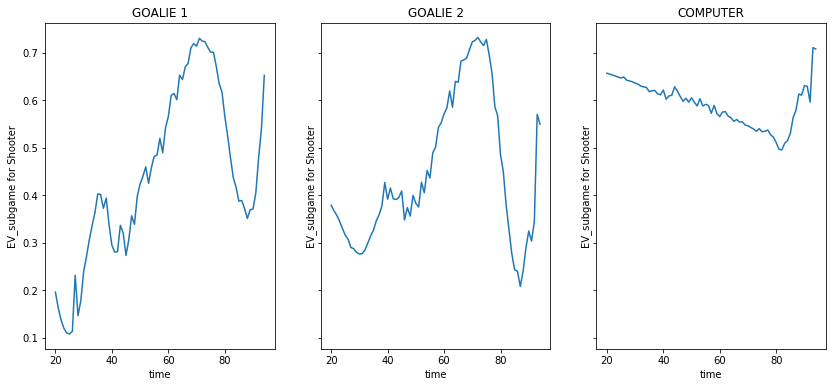

In [24]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,sharey=True,sharex=True,figsize=(14,6))

ax1.plot(goalie1groupdf.index, goalie1groupdf["EV"])
ax1.set_xlabel("time")
ax1.set_ylabel("EV_subgame for Shooter");
ax1.set_title("GOALIE 1")

ax2.plot(goalie2groupdf.index, goalie2groupdf["EV"])
ax2.set_xlabel("time")
ax2.set_ylabel("EV_subgame for Shooter");
ax2.set_title("GOALIE 2")

ax3.plot(cpugroupdf.index, cpugroupdf["EV"])
ax3.set_xlabel("time")
ax3.set_ylabel("EV_subgame for Shooter");
ax3.set_title("COMPUTER");

In [26]:
df_goalie1["subID"] = Vnoswitchdf.loc[df_goalie1.index].subID
df_goalie2["subID"] = Vnoswitchdf.loc[df_goalie2.index].subID
df_cpu["subID"] = Vnoswitchdf.loc[df_cpu.index].subID

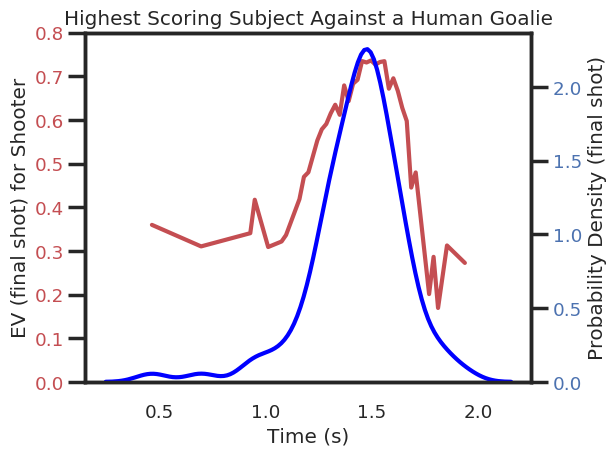

In [27]:
sns.reset_defaults()
sns.set(style="white",context='poster', font_scale=.60,font='arial')

fig, ax1 = plt.subplots()
sub = df_goalie2[df_goalie2["subID"]==50] #highest scoring subject against human goalie
bestgrouped = sub.groupby(["time"]).mean()

ax1.plot(bestgrouped.index/47.5, bestgrouped["EV"],c='r',label='Final Shot Expected Value')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("EV (final shot) for Shooter");
ax1.set_title("Highest Scoring Subject Against a Human Goalie")
ax1.set_ylim((0,.8))
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2 = sns.kdeplot(sub["time"]/47.5,color='blue',legend=False,label='Observed Placement of Final Changes')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("Probability Density (final shot)")
#fig.legend(bbox_to_anchor=(1.6, 1.0))
fig.tight_layout()
plt.savefig("presentationplots/EVsubgame_HighScoreSub_humangoalie.svg",bbox_inches='tight')

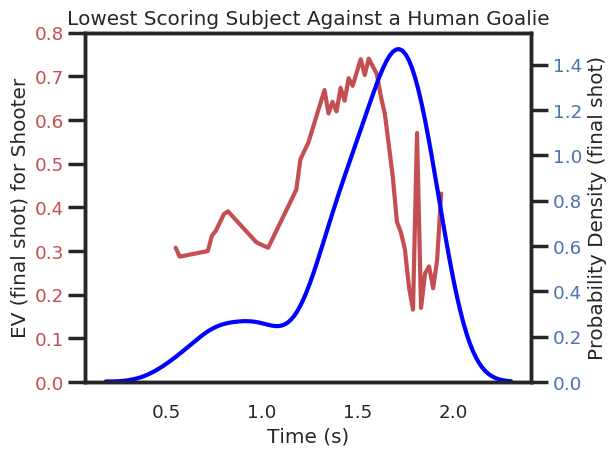

In [28]:
sns.reset_defaults()
sns.set(style="white",context='poster', font_scale=.60,font='arial')

fig, ax1 = plt.subplots()
sub = df_goalie2[df_goalie2["subID"]==79] #worst sub against human goalie
grouped = sub.groupby(["time"]).mean()

ax1.plot(grouped.index/47.5, grouped["EV"],c='r')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("EV (final shot) for Shooter");
ax1.set_title("Lowest Scoring Subject Against a Human Goalie")
ax1.set_ylim((0,.8))
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2 = sns.kdeplot(sub["time"]/47.5,color='blue',legend=False)
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("Probability Density (final shot)")
fig.tight_layout()
plt.savefig("presentationplots/EVsubgame_LowScoreSub_HumanGoalie.svg",bbox_inches='tight')

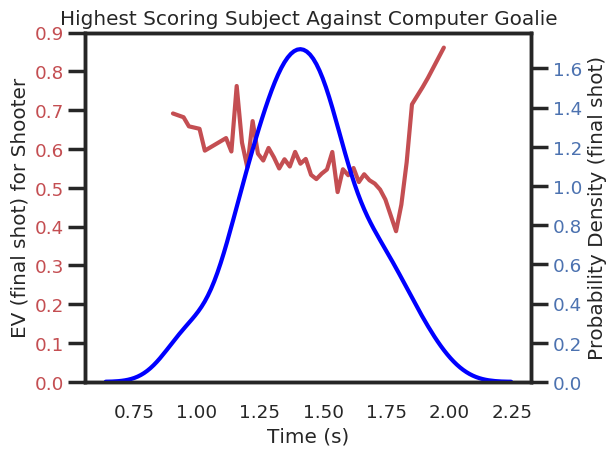

In [29]:
sns.reset_defaults()
sns.set(style="white",context='poster', font_scale=.60,font='arial')

fig, ax1 = plt.subplots()
sub = df_cpu[df_cpu["subID"]==45]
subgroup = sub.groupby(["time"]).mean()

ax1.plot(subgroup.index/47.5, subgroup["EV"],c='r')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("EV (final shot) for Shooter");
ax1.set_title("Highest Scoring Subject Against Computer Goalie")
ax1.set_ylim((0,.9))
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2 = sns.kdeplot(sub["time"]/47.5,color='blue',legend=False)
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("Probability Density (final shot)")
fig.tight_layout()
plt.savefig("presentationplots/EVsubgame_HighScoreSub_CPUGoalie.svg",bbox_inches='tight')

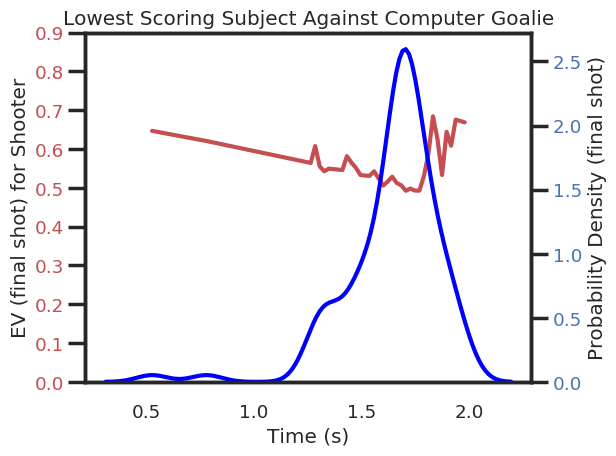

In [30]:
sns.reset_defaults()
sns.set(style="white",context='poster', font_scale=.60,font='arial')

fig, ax1 = plt.subplots()
sub = df_cpu[df_cpu["subID"]==54]
subgroup = sub.groupby(["time"]).mean()

ax1.plot(subgroup.index/47.5, subgroup["EV"],c='r')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("EV (final shot) for Shooter");
ax1.set_title("Lowest Scoring Subject Against Computer Goalie")
ax1.set_ylim((0,.9))
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2 = sns.kdeplot(sub["time"]/47.5,color='blue',legend=False)
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylabel("Probability Density (final shot)")
fig.tight_layout()
plt.savefig("presentationplots/EVsubgame_LowScoreSub_CPUGoalie.svg",bbox_inches='tight')

In [31]:
GPdata.columns

Index(['super_index', 'time', 'result', 'subID', 'goalieypos', 'ball_xpos',
       'ball_ypos', 'goalie_yvel', 'ball_yvel', 'opp', 'tslc',
       'shooterswitches'],
      dtype='object')

In [37]:
def calculateEVsubgame_entiretraj(m, goalieID, subID):
    """
    calculate the EV from the observed outcome
    feed in a particular goalie EV no switch model
    """
    
    allsubdf = GPdata[GPdata.subID==subID]
    allsubdf_human = allsubdf[allsubdf.opp==1]
    allsubdf_cpu = allsubdf[allsubdf.opp==0]
    
    if goalieID == 'cpu':
        inputdata = allsubdf_cpu[['goalieypos', 'ball_xpos',"ball_ypos","goalie_yvel","ball_yvel","opp","tslc","super_index","time"]]
        datatoreturn = inputdata.copy()
        del allsubdf_cpu["super_index"]
        del allsubdf_cpu["time"]
    else: #if human goalie
        inputdata = allsubdf_human[['goalieypos', 'ball_xpos',"ball_ypos","goalie_yvel","ball_yvel","opp","tslc","super_index","time"]]
        datatoreturn = inputdata.copy()
        del allsubdf_human["super_index"]
        del allsubdf_human["time"]
    EVs = []
    Xfeatures_totaldata = np.array(inputdata, dtype=float)    
    dataset = tf.data.Dataset.from_tensor_slices(Xfeatures_totaldata)
    dataset = dataset.batch(len(inputdata))
    iterator = dataset.make_one_shot_iterator()
    data = iterator.get_next()
    m.initialize()   

    with tf.Session() as sess:
        EVprobs = m.predict_y(data.eval())[0]
    return EVprobs, datatoreturn

### Make version of figure for manuscript

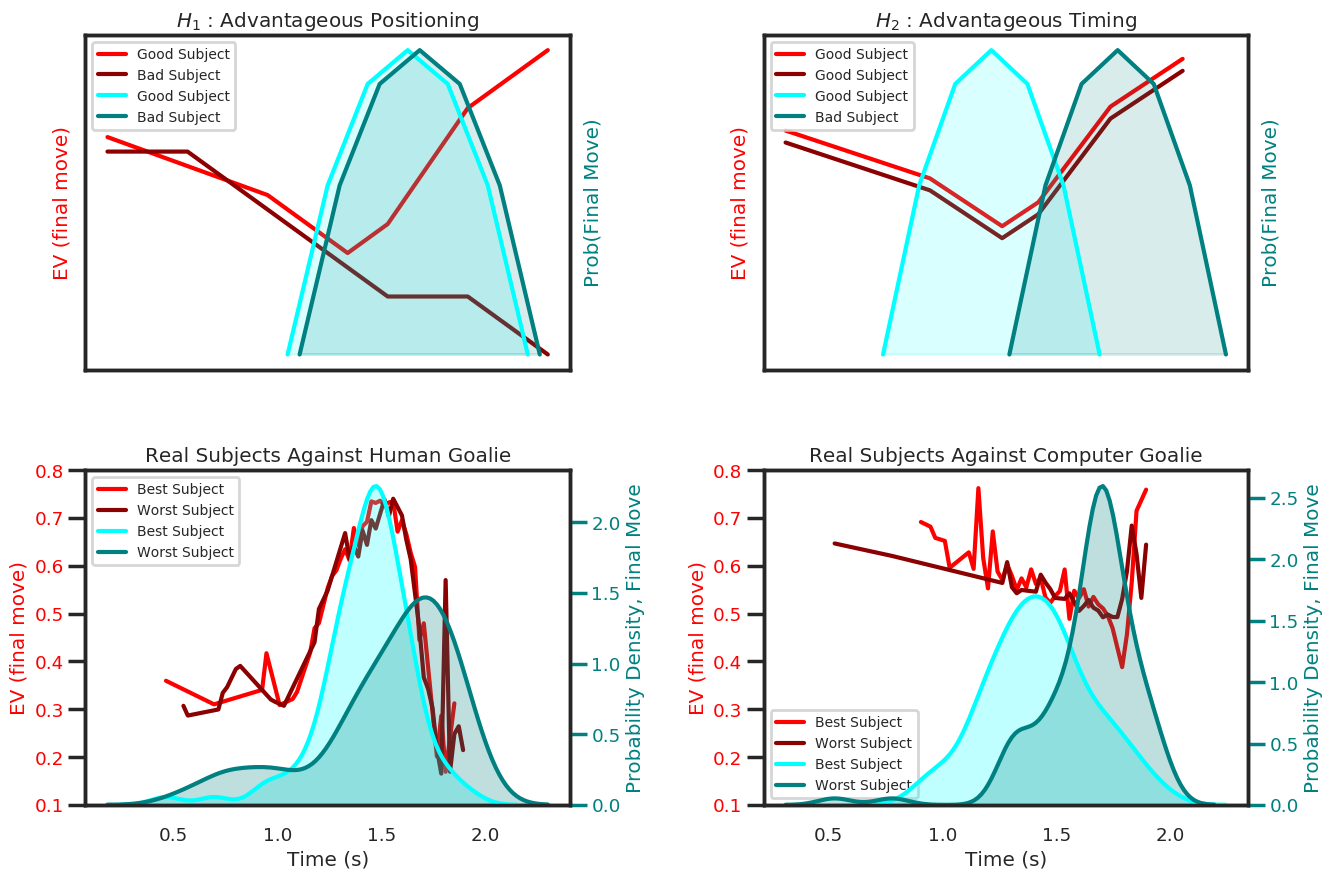

In [35]:
#subID, best sub against human = 50
#subID, worst sub against human = 79
#subID, best sub against computer = 45
#subID, worst sub against computer = 54

sns.reset_defaults()
sns.set(style="white",context='poster', font_scale=.60,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,10))

#H1 -- advantageous positioning schematic
ax1.plot([-6,-4,-2,-1,0,1,2,3,4,5],[10,9,8,7,6,7,9,11,12,13],c='red',label="Good Subject")
ax1.plot([-6,-4,-2,-1,0,1,2,3,4,5], [9.5, 9.5, 7.5, 6.5, 5.5, 4.5, 4.5, 4.5, 3.5, 2.5],c='darkred',label="Bad Subject")
x = [-3,-2,-1,0,1,2,3]
y = np.power(x,2)
ax1.tick_params(axis='y', labelcolor='r')
ax10 = ax1.twinx()
ax10.plot(np.array(x)+1.5,-y,c='cyan',label="Good Subject")
ax10.plot(np.array(x)+1.8, -y, c='teal', label='Bad Subject')
ax10.fill(np.array(x)+1.5, -y,c='cyan',alpha=0.15)
ax10.fill(np.array(x)+1.8, -y, c='teal',alpha=0.15)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax10.get_xaxis().set_ticks([])
ax10.get_yaxis().set_ticks([])
ax10.set_xlabel("Time (s)")
ax1.set_ylabel("EV (final move)",color='red',labelpad=10);
ax10.set_ylabel("Prob(Final Move)",color='teal',labelpad=10)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax10.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2,prop={'size': 10})
ax1.set_title(r"$H_1$ : Advantageous Positioning")


#H2 -- advantageous timing
ax2.tick_params(axis='y', labelcolor='r')
ax20 = ax2.twinx()
ax20.plot(np.array(x)-.3,-y,c='cyan',label="Good Subject")
ax20.plot(np.array(x)+3.2, -y, c='teal', label='Bad Subject')
ax20.fill(np.array(x)-.3,-y,c='cyan',alpha=0.15)
ax20.fill(np.array(x)+3.2, -y, c='teal',alpha=0.15)
ax2.plot([-6,-4,-2,-1,0,1,2,3,4,5],[10,9,8,7,6,7,9,11,12,13],c='red',label="Good Subject")
ax2.plot([-6,-4,-2,-1,0,1,2,3,4,5],[9.5,8.5,7.5,6.5,5.5,6.5,8.5,10.5,11.5,12.5],c='darkred',label="Good Subject")
ax2.set_ylim((0,14))
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax20.get_xaxis().set_ticks([])
ax20.get_yaxis().set_ticks([])
ax20.set_xlabel("Time (s)")
ax2.set_ylabel("EV (final move)",color='red',labelpad=10);
ax20.set_ylabel("Prob(Final Move)",color='teal',labelpad=10)
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax20.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,prop={'size': 10})
ax2.set_title(r"$H_2$ : Advantageous Timing")


#H3 -- Real human data, both sources
ax3.tick_params(axis='y', labelcolor='red')
ax30 = ax3.twinx()
labels=['Best Subject', 'Worst Subject']
colors=['red','darkred']
for i, subID in enumerate([50, 79]):
    sub = df_goalie2[df_goalie2["subID"]==subID]
    group = sub.groupby(["time"]).mean()
    ax3.plot(group.index[group.index<91]/47.5, group["EV"].loc[:90],
             color=colors[i],alpha=1.0,label=labels[i])
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("EV (final move)", color='red');
sub = df_goalie2[df_goalie2["subID"]==50]
subgroup = sub.groupby(["time"]).mean()
ax30 = sns.kdeplot(sub["time"]/47.5,color='cyan',legend=False,shade=True)
sub = df_goalie2[df_goalie2["subID"]==79]
subgroup = sub.groupby(["time"]).mean()
sns.kdeplot(sub["time"]/47.5,color='teal',legend=False,ax=ax30,shade=True)
ax30.set_ylabel("Probability Density, Final Move",color='teal')
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax30.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + ["Best Subject","Worst Subject"],prop={'size': 10},loc='upper left')
ax3.set_title("Real Subjects Against Human Goalie")
ax30.tick_params(axis='y', colors='teal')
ax3.set_ylim((0.10,.8))


#H4 -- Real cpu data, both sources
ax4.tick_params(axis='y', labelcolor='red')
ax40 = ax4.twinx()
labels=['Best Subject', 'Worst Subject']
colors=['red','darkred']
for i, subID in enumerate([45, 54]):
    sub = df_cpu[df_cpu["subID"]==subID]
    group = sub.groupby(["time"]).mean()
    ax4.plot(group.index[group.index<91]/47.5, group["EV"].loc[:90],
             color=colors[i],alpha=1.0,label=labels[i])
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("EV (final move)", color='red');
ax4.set_ylim(ax3.get_ylim())
sub = df_cpu[df_cpu["subID"]==45]
subgroup = sub.groupby(["time"]).mean()
ax40 = sns.kdeplot(sub["time"]/47.5,color='cyan',legend=False,shade=True)
sub = df_cpu[df_cpu["subID"]==54]
subgroup = sub.groupby(["time"]).mean()
sns.kdeplot(sub["time"]/47.5,color='teal',legend=False,ax=ax40,shade=True)
ax40.set_ylabel("Probability Density, Final Move",color='teal')
lines, labels = ax4.get_legend_handles_labels()
lines2, labels2 = ax40.get_legend_handles_labels()
ax4.legend(lines + lines2, labels + ["Best Subject","Worst Subject"],prop={'size': 10},loc='lower left')
ax4.set_title("Real Subjects Against Computer Goalie")
ax40.tick_params(axis='y', colors='teal')

fig.subplots_adjust(hspace=0.3,wspace=0.4)

#plt.savefig("presentationplots/EVsubgame_schematic.svg",bbox_inches='tight')

### Calculate $\mathbb{E}|t_{\mathrm{move}} - t_{\mathrm{move}}^{\mathrm{opt}}|$, where $t_{\mathrm{move}}$ is the changepoint location and $t_{\mathrm{move}}^{\mathrm{opt}}$ is the maximum shooter's expected value of placing a switching at time location $t$

In [39]:
#GOALIE 1
mGoalie = m_goalie1
goalieID = 'Goalie1'
lastcps_goalie1 = []
maxEVtimepoints_goalie1 = []
subIDs_goalie1 = []
trialindexes_goalie1 = []

for subID in df_goalie1.subID.unique():
    EVprobs, subdf = calculateEVsubgame_entiretraj(mGoalie, goalieID, subID)
    subdf["EVsubgame"] = EVprobs
    df_goalie1["super_index"] = Vnoswitchdf.loc[df_goalie1.index].super_index
    sublastcps = df_goalie1[df_goalie1.subID==subID].time
    df = df_goalie1.copy()
    
    for trial in subdf.super_index.unique():
        trialdf = subdf[subdf["super_index"]==trial]
        if len(df_goalie1[df_goalie1.super_index==trial]) > 0:
            trialindexes_goalie1.append(trial)
            thistriallastcp = df_goalie1[df_goalie1.super_index==trial].time.iloc[0]
            maxEVpoint = np.argmax(trialdf["EVsubgame"])
            maxEVtimeidx = trialdf.loc[maxEVpoint].time

            lastcps_goalie1.append(thistriallastcp)
            maxEVtimepoints_goalie1.append(maxEVtimeidx)
            subIDs_goalie1.append(subID)

In [41]:
#GOALIE 2
mGoalie = m_goalie2
goalieID = 'Goalie2'
lastcps_goalie2 = []
maxEVtimepoints_goalie2 = []
subIDs_goalie2 = []
trialindexes_goalie2 = []

for subID in df_goalie2.subID.unique():
    EVprobs, subdf = calculateEVsubgame_entiretraj(mGoalie, goalieID,subID)
    subdf["EVsubgame"] = EVprobs
    df_goalie2["super_index"] = Vnoswitchdf.loc[df_goalie2.index].super_index
    sublastcps = df_goalie2[df_goalie2.subID==subID].time
    df = df_goalie2.copy()
    
    for trial in subdf.super_index.unique():
        trialdf = subdf[subdf["super_index"]==trial]
        if len(df_goalie2[df_goalie2.super_index==trial]) > 0:
            trialindexes_goalie2.append(trial)
            thistriallastcp = df_goalie2[df_goalie2.super_index==trial].time.iloc[0]
            maxEVpoint = np.argmax(trialdf["EVsubgame"])
            maxEVtimeidx = trialdf.loc[maxEVpoint].time

            lastcps_goalie2.append(thistriallastcp)
            maxEVtimepoints_goalie2.append(maxEVtimeidx)
            subIDs_goalie2.append(subID)

In [42]:
#CPU
mGoalie = m_cpu
goalieID = 'cpu'
lastcps_cpu = []
maxEVtimepoints_cpu = []
subIDs_cpu = []
trialindexes_cpu = []

for subID in df_cpu.subID.unique():
    EVprobs, subdf = calculateEVsubgame_entiretraj(mGoalie, goalieID,subID)
    subdf["EVsubgame"] = EVprobs
    df_cpu["super_index"] = Vnoswitchdf.loc[df_cpu.index].super_index
    sublastcps = df_cpu[df_cpu.subID==subID].time
    df = df_cpu.copy()
    
    for trial in subdf.super_index.unique():
        trialdf = subdf[subdf["super_index"]==trial]
        if len(df_cpu[df_cpu.super_index==trial]) > 0:
            trialindexes_cpu.append(trial)
            thistriallastcp = df_cpu[df_cpu.super_index==trial].time.iloc[0]
            maxEVpoint = np.argmax(trialdf["EVsubgame"])
            maxEVtimeidx = trialdf.loc[maxEVpoint].time

            lastcps_cpu.append(thistriallastcp)
            maxEVtimepoints_cpu.append(maxEVtimeidx)
            subIDs_cpu.append(subID)

In [43]:
cpu = pd.DataFrame(lastcps_cpu, columns=["lastcp"])
cpu["maxEVtp"] = maxEVtimepoints_cpu
cpu["subID"] = subIDs_cpu
cpu["super_index"] = trialindexes_cpu


goalie1 = pd.DataFrame(lastcps_goalie1, columns=["lastcp"])
goalie1["maxEVtp"] = maxEVtimepoints_goalie1
goalie1["subID"] = subIDs_goalie1
goalie1["super_index"] = trialindexes_goalie1


goalie2 = pd.DataFrame(lastcps_goalie2, columns=["lastcp"])
goalie2["maxEVtp"] = maxEVtimepoints_goalie2
goalie2["subID"] = subIDs_goalie2
goalie2["super_index"] = trialindexes_goalie2

In [44]:
cpu["timediff"] = np.abs(cpu["lastcp"] - cpu["maxEVtp"])
goalie1["timediff"] = np.abs(goalie1["lastcp"] - goalie1["maxEVtp"])
goalie2["timediff"] = np.abs(goalie2["lastcp"] - goalie2["maxEVtp"])

In [45]:
cpusubavg = cpu.groupby(["subID"]).mean()["timediff"]
goalie1subavg = goalie1.groupby(["subID"]).mean()["timediff"]
goalie2subavg = goalie2.groupby(["subID"]).mean()["timediff"]

In [46]:
GPdata['subID'] = GPdata['subID'].astype('int')
winlossoppdf = GPdata.groupby(['super_index']).mean().groupby(['subID','opp']).mean()['result']

In [47]:
#get every subject's win rate against both human and computer goalie
cpusubjrates = winlossoppdf[::2].values
humansubjrates = winlossoppdf[1::2]
goalie1subjrates = humansubjrates[:50].values
goalie2subjrates = humansubjrates[50:].values

In [49]:
# Subject-average EV of final move and win rate against all opponents are highly correlated
print(stats.pearsonr(goalie1subjrates, df_goalie1.groupby(['subID']).mean()['EV']))
print(stats.pearsonr(goalie2subjrates, df_goalie2.groupby(['subID']).mean()['EV']))
print(stats.pearsonr(cpusubjrates, df_cpu.groupby(['subID']).mean()['EV']))

(0.6654308086323641, 1.3487047555749045e-07)
(0.6470646946802023, 6.275818879539656e-05)
(0.31090055170197234, 0.004470240301640487)


In [50]:
# Subject-average distance between final shot and EV max is highly correlated with win rates against all opponents
print(stats.pearsonr(cpusubavg, cpusubjrates))
print(stats.pearsonr(goalie1subavg, goalie1subjrates))
print(stats.pearsonr(goalie2subavg, goalie2subjrates))

(-0.3021986341863362, 0.005791734096245146)
(-0.482855218067716, 0.0003830480793253653)
(-0.48032558088411076, 0.005396448477643499)


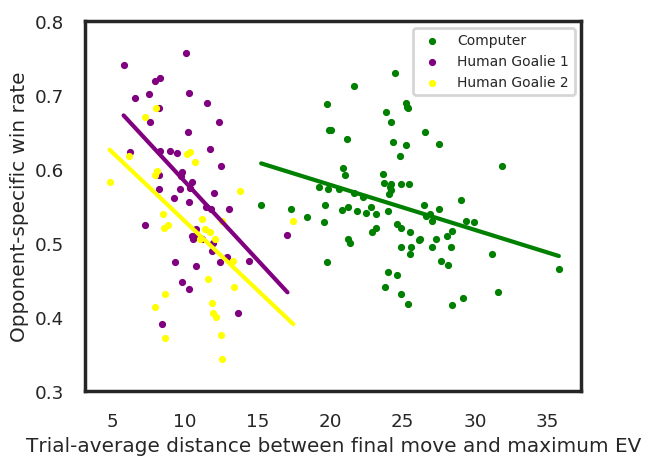

In [52]:
plt.scatter(cpusubavg, cpusubjrates,s=10,c='green',label="Computer")
plt.plot(np.unique(cpusubavg), np.poly1d(np.polyfit(cpusubavg, cpusubjrates, 1))(np.unique(cpusubavg)),c='green')

plt.scatter(goalie1subavg, goalie1subjrates,s=10,c='purple',label="Human Goalie 1")
plt.plot(np.unique(goalie1subavg), np.poly1d(np.polyfit(goalie1subavg, goalie1subjrates, 1))(np.unique(goalie1subavg)),c='purple')

plt.scatter(goalie2subavg, goalie2subjrates,s=10,c='yellow',label="Human Goalie 2")
plt.plot(np.unique(goalie2subavg), np.poly1d(np.polyfit(goalie2subavg, goalie2subjrates, 1))(np.unique(goalie2subavg)),c='yellow')

plt.legend(prop={'size':10})
plt.xlabel("Trial-average distance between final move and maximum EV")
plt.ylabel('Opponent-specific win rate');

axes = plt.gca()
axes.set_ylim([0.3,0.8]);
#plt.savefig("presentationplots/EVfinalmove_timedistanceandwin_population.svg",bbox_inches='tight')